In [2]:
from regression import*

Using TensorFlow backend.


# ML

In [3]:
# Load Data
feature = 'vind'
target = 'distance'

# Synthetic Data
data_dict_synth = get_synth_dataset('dataset_00', as_dict=True)
data_synth = DATA( data_dict_synth[feature][:,50:], data_dict_synth[target][:,50:]) 

# Measured Data
data_meas = DATA([],[])
for dataset_name in ['dataset_05','dataset_06','dataset_07']:
    data_dict_meas = get_measured_dataset(dataset_name, resample_dt=.1, as_dict=True)
    data_meas_n = DATA( data_dict_meas[feature], data_dict_meas[target])
    data_meas = data_meas.merge(data_meas_n)

In [206]:
# Processing
data_synth = data_synth.bound(max_value=10).standardize()    
data_meas = data_meas.standardize()    

In [207]:
# Segment
win_size, step = 20, 1
data_synth_seg_df = data_synth.segment(win_size, step, as_df=True)    

In [208]:
exp_reg = setup(data_synth_seg_df,
                train_size = .7,
                target = 'target', 
                # normalize = True, 
                silent = True,
                session_id = 20
                )   


Setup Succesfully Completed!


In [200]:
compare_models()

In [209]:
model = tune_model('xgboost')

IntProgress(value=0, description='Processing: ', max=16)

Initiated  . . . . . . . . . . . . . . . . . .                12:25:19
Status     . . . . . . . . . . . . . . . . . .  Tuning Hyperparameters
ETC        . . . . . . . . . . . . . . . . . .         Calculating ETC

Empty DataFrame
Columns: [MAE, MSE, RMSE, R2, RMSLE, MAPE]
Index: []

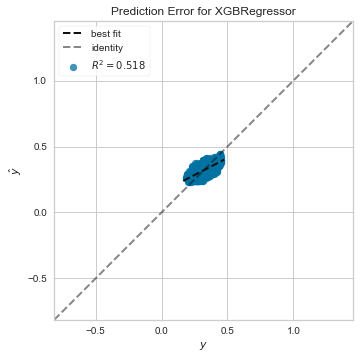

In [202]:
plot_model(model, plot='error')

In [25]:
pred = predict_model(model) 

Model     MAE     MSE    RMSE      R2  \
0  Extreme Gradient Boosting Regressor  0.0142  0.0003  0.0183  0.6877   

    RMSLE    MAPE  
0  0.0139  0.0454

In [203]:
def predict(x, y, win_size, step, doPlot=False, window_length=3):
    x_segmented = [ x[t:t+win_size] for t in range(0, len(y)-win_size, 1)]
    y_segmented = y[win_size:]
    data_n_df = pd.DataFrame( np.concatenate([x_segmented, np.reshape(y_segmented,(-1,1))], axis=1) )
    data_n_df.columns = [*['feature_'+str(i) for i in range(win_size)], 'target']

    prediction = predict_model(model, data=data_n_df)
    y_true = prediction.target
    y_pred = prediction.Label
    y_pred = signal.savgol_filter( y_pred, window_length=window_length, polyorder=1)  

    if doPlot:
        plt.plot(y_true, label='True Value')
        plt.plot(y_pred, label='Prediction')
        plt.legend()
        plt.show()
    
    return y_true, y_pred

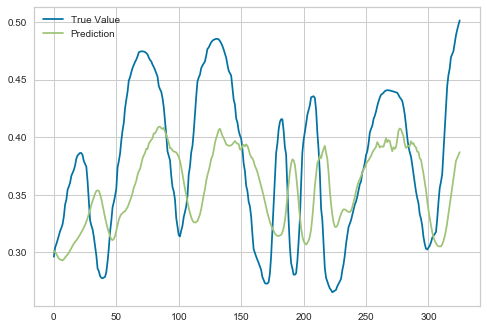

In [205]:
data = data_meas
metrics = defaultdict(list)

# for n in range(len(data.X)):
for n in [0]:    
    y_true, y_pred = predict(data.X[n], data.Y[n], win_size, step, doPlot=True, window_length=5)
    metrics['r2'].append( r2_score(y_true, y_pred) )
    metrics['mse'].append( mean_squared_error(y_true, y_pred) )
    metrics['rmse'].append( sqrt( mean_squared_error(y_true, y_pred)) )    
   

In [33]:
for key,value in metrics.items():
    print(key, np.mean(np.abs(value)))

r2 0.7183271294751482
mse 0.002891460320536749
rmse 0.04917682560232303


# RNN

In [132]:

####################################################################################################################################################
class REGRESSOR(object):
    ################################################################################################################################################
    def __init__(self, win_size, step=1, **params ):
        np.random.seed(7)        
        self.win_size = win_size
        self.step = step                
        self.build_model(**params)
    ################################################################################################################################################
    def train(self, train_data, epochs=30, verbose=0, show=True):        
        loss = list()        
        for n_epoch in range(epochs):
            display(n_epoch)            
            ep_loss = list()            
            for i in range(0, np.shape(train_data.X)[1]-self.win_size, self.step):
                history = self.model.fit( 
                    np.reshape( train_data.X[:, i:i+self.win_size], (-1, self.win_size, 1)), 
                    train_data.Y[:, i+self.win_size-1], 
                    epochs = 1, 
                    verbose = verbose
                )    
                ep_loss.append(history.history['loss'])
            
            loss.append(ep_loss)
            clear_output(wait=True)
            
            if show:
                plt.plot( np.ndarray.flatten( np.array(loss)) )
                plt.show()
                
        return np.array(loss)
    ################################################################################################################################################    
    def predict(self, X):
        predictions = list()
        for i in range(0, np.shape(X)[1]-self.win_size, 1):
            x = np.reshape( X[:, i:i+self.win_size], (-1, self.win_size, 1)) 
            pred = self.model.predict( x )
            predictions.append(pred)
        predictions = np.array(predictions)
        return predictions.reshape((-1, np.shape(predictions)[1])).transpose()  
####################################################################################################################################################
class RNN(REGRESSOR):
    def build_model(self, Nunits=3, Nhiddenlayer=1, activation='linear'):        
        self.model = Sequential()           
        self.model.add( LSTM(units=Nunits, activation=activation, return_sequences=True, input_shape=(self.win_size,1)) )  
        for n in range(Nhiddenlayer): self.model.add( LSTM(units=Nunits, activation=activation, return_sequences=True) )        
        self.model.add( LSTM(units=Nunits, activation=activation, return_sequences=True) )        
        self.model.add( LSTM(units=Nunits, activation='sigmoid'))   
        # self.model.add(Dropout(0.1))
        self.model.add( Dense(1))          
            
        self.model.compile(loss='mse', optimizer=RMSprop(lr=.001))        
        print(self.model.summary())        
        return 
####################################################################################################################################################
class TCN(REGRESSOR):
    def build_model(self, Nlayers=2, nb_filters=5, activation=None, optimizer='adam', loss='mse' ):  
        i = tf.keras.Input(batch_shape=(None, self.win_size)) 
        if Nlayers>1:
            o = tcn.TCN(nb_filters=nb_filters, return_sequences=True)(i)
            for n in range(Nlayers-2): tcn.TCN(nb_filters=nb_filters, return_sequences=True)(o)    
            o = tcn.TCN(nb_filters=nb_filters, return_sequences=False)(o)
        else:
            o = tcn.TCN(nb_filters=nb_filters, return_sequences=False)(i)     
            
        o = tf.keras.layers.Dense(1, activation=activation)(o)
        self.model = tf.keras.Model(inputs=[i], outputs=[o])
        
        self.model.compile(loss='mse', optimizer='RMSprop', learning_rate=.001)        
        print(self.model.summary())                
        return 
####################################################################################################################################################


In [133]:
regressor = RNN(
    win_size = 40,
    Nhiddenlayer = 5,
    step = 10,
    Nunits = 50, 
    activation = 'tanh'
)

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_68 (LSTM)               (None, 40, 50)            10400     
_________________________________________________________________
lstm_69 (LSTM)               (None, 40, 50)            20200     
_________________________________________________________________
lstm_70 (LSTM)               (None, 40, 50)            20200     
_________________________________________________________________
lstm_71 (LSTM)               (None, 40, 50)            20200     
_________________________________________________________________
lstm_72 (LSTM)               (None, 40, 50)            20200     
_________________________________________________________________
lstm_73 (LSTM)               (None, 40, 50)            20200     
_________________________________________________________________
lstm_74 (LSTM)               (None, 40, 50)          

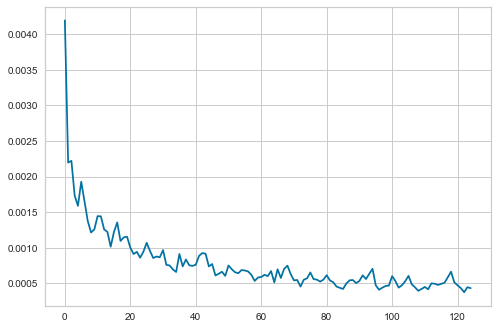

In [134]:
loss = regressor.train( data_synth, epochs=5 )

In [138]:
y_true = data_synth.Y[:5]
y_pred = regressor.predict_(data_synth.X[:5,:])

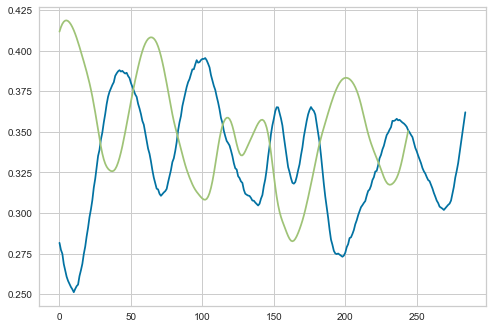

In [141]:
idx = 2
plt.plot(y_true[idx])
plt.plot(y_pred[idx])

In [ ]:
idx = 2
data = data_meas

x, y = data.X[idx], data.Y[idx]
x = np.reshape(x, (1, np.shape(x)[0], np.shape(x)[1]))
y = np.reshape(y, (1, np.shape(y)[0]))

y_pred_ = regressor.predict(x)
smoothed_predictions = signal.savgol_filter( predictions[0], window_length=11, polyorder=1, axis=0)       

plt.plot(y[0,regressor.win_size:])
plt.plot(predictions[0])
plt.plot(smoothed_predictions)
plt.show()

In [91]:
data_meas_mtx = data_meas.mtx()

IndexError: tuple index out of range